# Purpose
The purpose of this notebook is to emulate the SMS (semi-local momentum space) chiral potential using the NVP and KVP emulators. The potential has units of fm.

# Notebook Setup

## Importing Python libraries

In [1]:
import numpy as np
from numpy.typing import ArrayLike
from typing import Union, Optional
from ruamel.yaml import YAML
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py

%matplotlib inline
%load_ext autoreload    
%autoreload 2

## Importing local libraries

In [2]:
from emulate_kvp import setup_rc_params, plot_results
from emulate_kvp import plot_cross_section, plot_spin_obs
from emulate_kvp import compute_errors, spin_obs_errors
from emulate_kvp.utils import compute_mixed_S

from emulate_kvp import LHS_setup
from emulate_kvp import KVP_emulator
from emulate_kvp import Observables
from emulate_kvp import EmulateCrossSection
from emulate_kvp import EmulateSpinObservables

from emulate_nvp import BoundaryCondition
from emulate_nvp import ScatteringSystem
from emulate_nvp import TwoBodyScattering as NVP_emulator
from emulate_nvp import ObservablesEmulator

# Emulator setup

## Parameters

In [3]:
### PLOTTING ###
setup_rc_params(dpi=800)

### LHS PARAMETERS ###
mult_factor = 2 # Used to basis size: mult_factor * len(lecs) per partial wave
num_test = 500 # Size of testing arrays for emulator
vary_params = [-5, 5] # Range used for sampling parameter sets

### EMULATOR PARAMETERS ###
inc_param = False # If True, includes testing parameter set in training portion
emu_method = 'all' # Boundary conditions for emulator: 'K', '1/K', 'T', 'S', 'all'
solver = 'lstsq' # How to solve for prediction: 'lstsq', 'solve', 'pinv'
nugget = 1e-10 # Nugget for emulator calculations
seed = 1 # Random number seed for reproducibility

## Unpack potentials from h5 file for training

In [4]:
file_name = '../data/SMS_n4lo+_Lambda450MeV_jmax-20_np_5_036_402020.h5'

with h5py.File(file_name, "r") as f:
    jmax = int(f['jmax'][...])
    chiral_order = int(f['chiral_order'][...])
    cutoff = int(f['cutoff'][...])
    interaction = str(f['interaction'][...])[2:-1]
    
    E = f['E'][...]
    k = f['k'][...]
    degrees = f['degrees'][...]
    ps = f['ps'][...]
    ws = f['ws'][...]
    mesh_nodes = f['mesh_nodes'][...]
    pts_per_region = f['pts_per_region'][...]
    
    V_1S0 = f['V_1S0'][...]
    V0_1S0 = f['V0_1S0'][...]
    V1_1S0 = f['V1_1S0'][...]
    V_3P0 = f['V_3P0'][...]
    V0_3P0 = f['V0_3P0'][...]
    V1_3P0 = f['V1_3P0'][...]
    V_1P1 = f['V_1P1'][...]
    V0_1P1 = f['V0_1P1'][...]
    V1_1P1 = f['V1_1P1'][...]
    V_3P1 = f['V_3P1'][...]
    V0_3P1 = f['V0_3P1'][...]
    V1_3P1 = f['V1_3P1'][...]
    V_1D2 = f['V_1D2'][...]
    V0_1D2 = f['V0_1D2'][...]
    V1_1D2 = f['V1_1D2'][...]
    V_3D2 = f['V_3D2'][...]
    V0_3D2 = f['V0_3D2'][...]
    V1_3D2 = f['V1_3D2'][...]
    V_1F3 = f['V_1F3'][...]
    V0_1F3 = f['V0_1F3'][...]
    V1_1F3 = f['V1_1F3'][...]
    V_3F3 = f['V_3F3'][...]
    V0_3F3 = f['V0_3F3'][...]
    V1_3F3 = f['V1_3F3'][...]
    V_1 = f['V_1'][...]
    V_2 = f['V_2'][...]
    V_3S1_3D1 = f['V_3S1_3D1'][...]
    V0_3S1_3D1 = f['V0_3S1_3D1'][...]
    V1_3S1_3D1 = f['V1_3S1_3D1'][...]
    V_3P2_3F2 = f['V_3P2_3F2'][...]
    V0_3P2_3F2 = f['V0_3P2_3F2'][...]
    V1_3P2_3F2 = f['V1_3P2_3F2'][...]
    V_3D3_3G3 = f['V_3D3_3G3'][...]
    V0_3D3_3G3 = f['V0_3D3_3G3'][...]
    V1_3D3_3G3 = f['V1_3D3_3G3'][...]
    V_3F4_3H4 = f['V_3F4_3H4'][...]
    V0_3F4_3H4 = f['V0_3F4_3H4'][...]
    V1_3F4_3H4 = f['V1_3F4_3H4'][...]
    V_no_contacts = f['V_no_contacts'][...]

In [5]:
file_name_fine = '../data/SMS_n4lo+_Lambda450MeV_jmax-1_np_5_036_402020_fine.h5'

with h5py.File(file_name_fine, "r") as f:
    E_fine = f['E'][...]
    k_fine = f['k'][...]
    ps_fine = f['ps'][...]
    ws_fine = f['ws'][...]
    
    V0_1S0_fine = f['V0_1S0'][...]
    V1_1S0_fine = f['V1_1S0'][...]
    V0_3S1_3D1_fine = f['V0_3S1_3D1'][...]
    V1_3S1_3D1_fine = f['V1_3S1_3D1'][...]

In [6]:
V_no_contacts_reshape = np.reshape(V_no_contacts, 
                                  (int(V_no_contacts.shape[0] / 6), 
                                   6, 
                                   V_no_contacts.shape[2], 
                                   V_no_contacts.shape[3], 
                                   V_no_contacts.shape[4]))

In [7]:
### MESH PARAMETERS ###
ki = mesh_nodes[0] # Mesh initial point
cut_reg1 = mesh_nodes[1] # Mesh cutoff of first region
cut_reg2 = mesh_nodes[2] # Mesh cutoff of second region
kf = mesh_nodes[3] # Mesh cutoff

pts_reg1 = pts_per_region[0] # Total points in first region
pts_reg2 = pts_per_region[1] # Total points in second region
pts_reg3 = pts_per_region[2] # Total points in third region
Ntot = pts_reg1 + pts_reg2 + pts_reg3 # Total mesh size

## Get coupling constants from YAML file

In [8]:
if (cutoff == 1):
    value = 400
elif (cutoff == 2):
    value = 450
elif (cutoff == 3):
    value = 500
elif (cutoff == 4):
    value = 550
    
location = '../data/' + str(value) + 'MeV/'

yaml = YAML(typ="safe")
with open(location + 'sms_lecs_n4lop_lam' + str(value) + '.yaml', "r") as input_file:
    lecs_yaml = yaml.load(input_file)

In [9]:
lecs_1S0 = [val for key, val in lecs_yaml.items() if "1S0" in key]
lecs_3P0 = [val for key, val in lecs_yaml.items() if "3P0" in key]
lecs_1P1 = [val for key, val in lecs_yaml.items() if "1P1" in key]
lecs_3P1 = [val for key, val in lecs_yaml.items() if "3P1" in key]
lecs_1D2 = [val for key, val in lecs_yaml.items() if "1D2" in key]
lecs_3D2 = [val for key, val in lecs_yaml.items() if "3D2" in key]
lecs_1F3 = [val for key, val in lecs_yaml.items() if "1F3" in key]
lecs_3F3 = [val for key, val in lecs_yaml.items() if "3F3" in key]

lecs_3S1_3D1 = [val for key, val in lecs_yaml.items() if "3S1" in key or "3D1" in key]
lecs_3P2_3F2 = [val for key, val in lecs_yaml.items() if "3P2" in key or "3F2" in key]
lecs_3D3_3G3 = [val for key, val in lecs_yaml.items() if "3D3" in key or "3G3" in key]
lecs_3F4_3H4 = [val for key, val in lecs_yaml.items() if "3F4" in key or "3H4" in key]

# Emulator calculation

## Uncoupled channels

### Partial wave: 1S0

In [10]:
jmom, wave = 0, '1S0'
n_b_1S0 = mult_factor * len(lecs_1S0)

basis_1S0 = LHS_setup(lecs_1S0, vary_params, n_b_1S0, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1S0 = KVP_emulator(k, ps, ws, V0_1S0, V1_1S0, wave, is_coupled=False)
emu_1S0.train(basis_1S0, glockle=True, method=emu_method)
emu_1S0.train(basis_1S0, glockle=False, method=emu_method)

In [11]:
scatt_1S0 = NVP_emulator(
    V0=2 / np.pi * V0_1S0,
    V1=2 / np.pi * V1_1S0,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1S0.fit(basis_1S0);

#### Fine mesh

In [12]:
emu_1S0_fine = KVP_emulator(k_fine, ps_fine, ws_fine, V0_1S0_fine, 
                            V1_1S0_fine, wave, is_coupled=False)
emu_1S0_fine.train(basis_1S0, glockle=True, method=emu_method)
emu_pred_glockle_1S0 = emu_1S0_fine.prediction(lecs_1S0, glockle=True, 
                                               sol=solver, h=nugget)

emu_1S0_fine.train(basis_1S0, glockle=False, method=emu_method)
emu_pred_std_1S0 = emu_1S0_fine.prediction(lecs_1S0, glockle=False, 
                                           sol=solver, h=nugget)

sim_1S0 = emu_1S0_fine.high_fidelity(lecs_1S0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
scatt_1S0_fine = NVP_emulator(
    V0=2 / np.pi * V0_1S0_fine,
    V1=2 / np.pi * V1_1S0_fine,
    k=ps_fine, dk=ws_fine, t_lab=E_fine,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1S0_fine.fit(basis_1S0)

emu_pred_nvp_1S0 = scatt_1S0_fine.predict(lecs_1S0,  
                                          return_phase=False, 
                                          full_space=False)
sim_nvp_1S0 = scatt_1S0_fine.predict(lecs_1S0, 
                                     return_phase=False, 
                                     full_space=True)

#### Results with fine mesh

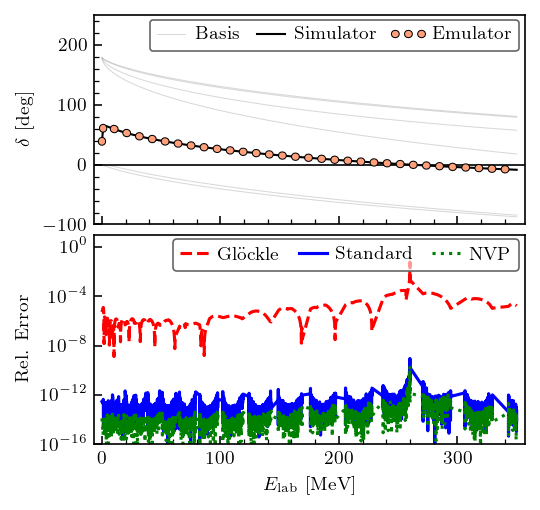

In [14]:
emu_pred_glockle_1S0_mix = compute_mixed_S(emu_pred_glockle_1S0)
emu_pred_std_1S0_mix = compute_mixed_S(emu_pred_std_1S0)

emu_results_1S0 = [emu_pred_glockle_1S0_mix, emu_pred_std_1S0_mix, emu_pred_nvp_1S0]
sim_results_1S0 = [sim_1S0, sim_1S0, sim_nvp_1S0]

plot_results(E_fine, emu_1S0_fine, sim_results_1S0, emu_results_1S0, value)

### Partial wave: 3P0

In [15]:
jmom, wave = 0, '3P0'
n_b_3P0 = mult_factor * len(lecs_3P0)

basis_3P0 = LHS_setup(lecs_3P0, vary_params, n_b_3P0, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3P0 = KVP_emulator(k, ps, ws, V0_3P0, V1_3P0, wave, is_coupled=False)
emu_3P0.train(basis_3P0, glockle=True, method=emu_method)
emu_3P0.train(basis_3P0, glockle=False, method=emu_method)

In [16]:
scatt_3P0 = NVP_emulator(
    V0=2 / np.pi * V0_3P0,
    V1=2 / np.pi * V1_3P0,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3P0.fit(basis_3P0);

### Partial wave: 1P1

In [17]:
jmom, wave = 1, '1P1'
n_b_1P1 = mult_factor * len(lecs_1P1)

basis_1P1 = LHS_setup(lecs_1P1, vary_params, n_b_1P1, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1P1 = KVP_emulator(k, ps, ws, V0_1P1, V1_1P1, wave, is_coupled=False)
emu_1P1.train(basis_1P1, glockle=True, method=emu_method)
emu_1P1.train(basis_1P1, glockle=False, method=emu_method)

In [18]:
scatt_1P1 = NVP_emulator(
    V0=2 / np.pi * V0_1P1,
    V1=2 / np.pi * V1_1P1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1P1.fit(basis_1P1);

### Partial wave: 3P1

In [19]:
jmom, wave = 1, '3P1'
n_b_3P1 = mult_factor * len(lecs_3P1)

basis_3P1 = LHS_setup(lecs_3P1, vary_params, n_b_3P1, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3P1 = KVP_emulator(k, ps, ws, V0_3P1, V1_3P1, wave, is_coupled=False)
emu_3P1.train(basis_3P1, glockle=True, method=emu_method)
emu_3P1.train(basis_3P1, glockle=False, method=emu_method)

In [20]:
scatt_3P1 = NVP_emulator(
    V0=2 / np.pi * V0_3P1,
    V1=2 / np.pi * V1_3P1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3P1.fit(basis_3P1);

### Partial wave: 1D2

In [21]:
jmom, wave = 2, '1D2'
n_b_1D2 = mult_factor * len(lecs_1D2)

basis_1D2 = LHS_setup(lecs_1D2, vary_params, n_b_1D2, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1D2 = KVP_emulator(k, ps, ws, V0_1D2, V1_1D2, wave, is_coupled=False)
emu_1D2.train(basis_1D2, glockle=True, method=emu_method)
emu_1D2.train(basis_1D2, glockle=False, method=emu_method)

In [22]:
scatt_1D2 = NVP_emulator(
    V0=2 / np.pi * V0_1D2,
    V1=2 / np.pi * V1_1D2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1D2.fit(basis_1D2);

### Partial wave: 3D2

In [23]:
jmom, wave = 2, '3D2'
n_b_3D2 = mult_factor * len(lecs_3D2)

basis_3D2 = LHS_setup(lecs_3D2, vary_params, n_b_3D2, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3D2 = KVP_emulator(k, ps, ws, V0_3D2, V1_3D2, wave, is_coupled=False)
emu_3D2.train(basis_3D2, glockle=True, method=emu_method)
emu_3D2.train(basis_3D2, glockle=False, method=emu_method)

In [24]:
scatt_3D2 = NVP_emulator(
    V0=2 / np.pi * V0_3D2,
    V1=2 / np.pi * V1_3D2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3D2.fit(basis_3D2);

### Partial wave: 1F3

In [25]:
jmom, wave = 3, '1F3'
n_b_1F3 = mult_factor * len(lecs_1F3)

basis_1F3 = LHS_setup(lecs_1F3, vary_params, n_b_1F3, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_1F3 = KVP_emulator(k, ps, ws, V0_1F3, V1_1F3, wave, is_coupled=False)
emu_1F3.train(basis_1F3, glockle=True, method=emu_method)
emu_1F3.train(basis_1F3, glockle=False, method=emu_method)

In [26]:
scatt_1F3 = NVP_emulator(
    V0=2 / np.pi * V0_1F3,
    V1=2 / np.pi * V1_1F3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_1F3.fit(basis_1F3);

### Partial wave: 3F3

In [27]:
jmom, wave = 3, '3F3'
n_b_3F3 = mult_factor * len(lecs_3F3)

basis_3F3 = LHS_setup(lecs_3F3, vary_params, n_b_3F3, num_test, 
                      inc_param=inc_param, fix_seed=seed)[0]

emu_3F3 = KVP_emulator(k, ps, ws, V0_3F3, V1_3F3, wave, is_coupled=False)
emu_3F3.train(basis_3F3, glockle=True, method=emu_method)
emu_3F3.train(basis_3F3, glockle=False, method=emu_method)

In [28]:
scatt_3F3 = NVP_emulator(
    V0=2 / np.pi * V0_3F3,
    V1=2 / np.pi * V1_3F3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)
scatt_3F3.fit(basis_3F3);

## Coupled channels

### Partial wave: 3S1/3D1

In [29]:
jmom, wave = 1, '3S1/3D1'
n_b_3S1_3D1 = mult_factor * len(lecs_3S1_3D1)

basis_3S1_3D1 = LHS_setup(lecs_3S1_3D1, vary_params, n_b_3S1_3D1, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3S1_3D1 = KVP_emulator(k, ps, ws, V0_3S1_3D1, V1_3S1_3D1, wave, is_coupled=True)
emu_3S1_3D1.train(basis_3S1_3D1, glockle=True, method=emu_method)
emu_3S1_3D1.train(basis_3S1_3D1, glockle=False, method=emu_method)

In [30]:
scatt_3S1_3D1 = NVP_emulator(
    V0=2 / np.pi * V0_3S1_3D1,
    V1=2 / np.pi * V1_3S1_3D1,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3S1_3D1.fit(basis_3S1_3D1);

#### Fine mesh

In [31]:
emu_3S1_3D1_fine = KVP_emulator(k_fine, ps_fine, ws_fine, V0_3S1_3D1_fine, 
                                V1_3S1_3D1_fine, wave, is_coupled=True)
emu_3S1_3D1_fine.train(basis_3S1_3D1, glockle=True, method=emu_method)
emu_pred_glockle_3S1_3D1 = emu_3S1_3D1_fine.prediction(lecs_3S1_3D1, glockle=True, 
                                                       sol=solver, h=nugget)

emu_3S1_3D1_fine.train(basis_3S1_3D1, glockle=False, method=emu_method)
emu_pred_std_3S1_3D1 = emu_3S1_3D1_fine.prediction(lecs_3S1_3D1, glockle=False, 
                                                   sol=solver, h=nugget)

sim_3S1_3D1 = emu_3S1_3D1_fine.high_fidelity(lecs_3S1_3D1)

In [32]:
scatt_3S1_3D1_fine = NVP_emulator(
    V0=2 / np.pi * V0_3S1_3D1_fine,
    V1=2 / np.pi * V1_3S1_3D1_fine,
    k=ps_fine, dk=ws_fine, t_lab=E_fine,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3S1_3D1_fine.fit(basis_3S1_3D1)

emu_pred_nvp_3S1_3D1 = scatt_3S1_3D1_fine.predict(lecs_3S1_3D1, 
                                                  return_phase=False, 
                                                  full_space=False)
sim_nvp_3S1_3D1 = scatt_3S1_3D1_fine.predict(lecs_3S1_3D1, 
                                             return_phase=False, 
                                             full_space=True)

#### Results with fine mesh

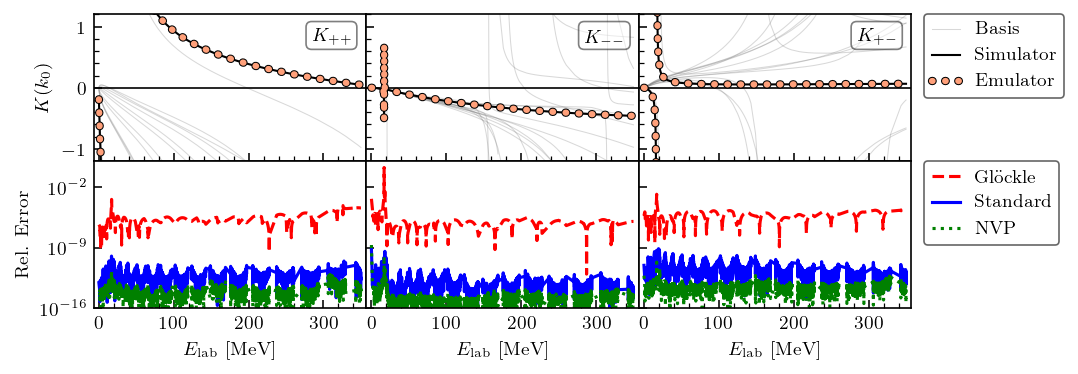

In [33]:
emu_pred_glockle_3S1_3D1_mix = compute_mixed_S(emu_pred_glockle_3S1_3D1)
emu_pred_std_3S1_3D1_mix = compute_mixed_S(emu_pred_std_3S1_3D1)

emu_results_3S1_3D1 = [emu_pred_glockle_3S1_3D1_mix, 
                       emu_pred_std_3S1_3D1_mix, 
                       emu_pred_nvp_3S1_3D1]
sim_results_3S1_3D1 = [sim_3S1_3D1, sim_3S1_3D1, sim_nvp_3S1_3D1]

plot_results(E_fine, emu_3S1_3D1_fine, sim_results_3S1_3D1, emu_results_3S1_3D1, value)

### Partial wave: 3P2/3F2

In [34]:
jmom, wave = 2, '3P2/3F2'
n_b_3P2_3F2 = mult_factor * len(lecs_3P2_3F2)

basis_3P2_3F2 = LHS_setup(lecs_3P2_3F2, vary_params, n_b_3P2_3F2, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3P2_3F2 = KVP_emulator(k, ps, ws, V0_3P2_3F2, V1_3P2_3F2, wave, is_coupled=True)
emu_3P2_3F2.train(basis_3P2_3F2, glockle=True, method=emu_method)
emu_3P2_3F2.train(basis_3P2_3F2, glockle=False, method=emu_method)

In [35]:
scatt_3P2_3F2 = NVP_emulator(
    V0=2 / np.pi * V0_3P2_3F2,
    V1=2 / np.pi * V1_3P2_3F2,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3P2_3F2.fit(basis_3P2_3F2);

### Partial wave: 3D3/3G3

In [36]:
jmom, wave = 3, '3D3/3G3'
n_b_3D3_3G3 = mult_factor * len(lecs_3D3_3G3)

basis_3D3_3G3 = LHS_setup(lecs_3D3_3G3, vary_params, n_b_3D3_3G3, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3D3_3G3 = KVP_emulator(k, ps, ws, V0_3D3_3G3, V1_3D3_3G3, wave, is_coupled=True)
emu_3D3_3G3.train(basis_3D3_3G3, glockle=True, method=emu_method)
emu_3D3_3G3.train(basis_3D3_3G3, glockle=False, method=emu_method)

In [37]:
scatt_3D3_3G3 = NVP_emulator(
    V0=2 / np.pi * V0_3D3_3G3,
    V1=2 / np.pi * V1_3D3_3G3,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3D3_3G3.fit(basis_3D3_3G3);

### Partial wave: 3F4/3H4

In [38]:
jmom, wave = 4, '3F4/3H4'
n_b_3F4_3H4 = mult_factor * len(lecs_3F4_3H4)

basis_3F4_3H4 = LHS_setup(lecs_3F4_3H4, vary_params, n_b_3F4_3H4, num_test, 
                          inc_param=inc_param, fix_seed=seed)[0]

emu_3F4_3H4 = KVP_emulator(k, ps, ws, V0_3F4_3H4, V1_3F4_3H4, wave, is_coupled=True)
emu_3F4_3H4.train(basis_3F4_3H4, glockle=True, method=emu_method)
emu_3F4_3H4.train(basis_3F4_3H4, glockle=False, method=emu_method)

In [39]:
scatt_3F4_3H4 = NVP_emulator(
    V0=2 / np.pi * V0_3F4_3H4,
    V1=2 / np.pi * V1_3F4_3H4,
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    is_coupled=True,
    nugget=nugget,
)
scatt_3F4_3H4.fit(basis_3F4_3H4);

## Emulating the total cross section

### Getting KVP emulators

In [40]:
jmom, wave = 4, None

emu_1 = KVP_emulator(k, ps, ws, V_1, 0, wave, is_coupled=False)
emu_2 = KVP_emulator(k, ps, ws, V_2, 0, wave, is_coupled=False)

In [41]:
inputs_uncoupled = [
    [0, lecs_1S0, V_1S0, emu_1S0],
    [0, lecs_3P0, V_3P0, emu_3P0],
    [1, lecs_1P1, V_1P1, emu_1P1],
    [1, lecs_3P1, V_3P1, emu_3P1],
    [2, lecs_1D2, V_1D2, emu_1D2],
    [2, lecs_3D2, V_3D2, emu_3D2],
    [3, lecs_1F3, V_1F3, emu_1F3],
    [3, lecs_3F3, V_3F3, emu_3F3],
    [4, None, V_1, emu_1],
    [4, None, V_2, emu_2],
]

inputs_coupled = [
    [1, lecs_3S1_3D1, V_3S1_3D1, emu_3S1_3D1],
    [2, lecs_3P2_3F2, V_3P2_3F2, emu_3P2_3F2],
    [3, lecs_3D3_3G3, V_3D3_3G3, emu_3D3_3G3],
    [4, lecs_3F4_3H4, V_3F4_3H4, emu_3F4_3H4],
]

inputs_no_contacts = [
    [j + 5, 
     None, 
     V_no_contacts_reshape[j][idx], 
     KVP_emulator(k, ps, ws, V_no_contacts_reshape[j][idx], 0, None)
    ] 
    for j in range(jmax - 4) for idx in range(6)
]

inputs_all = inputs_uncoupled + inputs_coupled + inputs_no_contacts
js, lecs, potentials, emulators = list(zip(*inputs_all))

### Getting NVP emulators

In [42]:
scatt_1 = NVP_emulator(
    V0=2 / np.pi * V_1,
    V1=2 / np.pi * np.zeros_like(V_1[..., None]),
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)

scatt_2 = NVP_emulator(
    V0=2 / np.pi * V_2,
    V1=2 / np.pi * np.zeros_like(V_2[..., None]),
    k=ps, dk=ws, t_lab=E,
    system=ScatteringSystem(interaction),
    boundary_condition=BoundaryCondition.STANDING,
    nugget=nugget,
)

In [43]:
inputs_uncoupled_nvp = [
    [0, lecs_1S0, scatt_1S0],
    [0, lecs_3P0, scatt_3P0],
    [1, lecs_1P1, scatt_1P1],
    [1, lecs_3P1, scatt_3P1],
    [2, lecs_1D2, scatt_1D2],
    [2, lecs_3D2, scatt_3D2],
    [3, lecs_1F3, scatt_1F3],
    [3, lecs_3F3, scatt_3F3],
    [4, None, scatt_1],
    [4, None, scatt_2],
]

inputs_coupled_nvp = [
    [1, lecs_3S1_3D1, scatt_3S1_3D1],
    [2, lecs_3P2_3F2, scatt_3P2_3F2],
    [3, lecs_3D3_3G3, scatt_3D3_3G3],
    [4, lecs_3F4_3H4, scatt_3F4_3H4],
]

inputs_no_contacts_nvp = [
    [j + 5, 
     None,  
     NVP_emulator(
        V0=2 / np.pi * V_no_contacts_reshape[j][idx],
        V1=2 / np.pi * np.zeros_like(V_no_contacts_reshape[j][idx][..., None]),
        k=ps, dk=ws, t_lab=E,
        system=ScatteringSystem(interaction),
        boundary_condition=BoundaryCondition.STANDING,
        nugget=nugget,
    )
    ] 
    for j in range(jmax - 4) for idx in range(6)
]

inputs_all_nvp = inputs_uncoupled_nvp + inputs_coupled_nvp + inputs_no_contacts_nvp

j_nvp, lecs_nvp, emulators_nvp = list(zip(*inputs_all_nvp))

### Getting LECs

In [44]:
true_lecs = lecs_1S0 +  lecs_3P0 + lecs_1P1 + \
            lecs_3P1 + lecs_1D2 + lecs_3D2 + \
            lecs_1F3 + lecs_3F3 + lecs_3S1_3D1 + \
            lecs_3P2_3F2 + lecs_3D3_3G3 + lecs_3F4_3H4

lec_test_all = LHS_setup(true_lecs, vary_params, 0, num_test, fix_seed=seed)[1]
true_lecs_arr = np.array(true_lecs)
print(lec_test_all.shape)

(500, 25)


## Total cross section emulation

In [45]:
compute_obs = Observables(E, k, degrees)
get_cs = EmulateCrossSection(js, lecs, emulators, solver)
nvp_obs = ObservablesEmulator(emulators_nvp, lecs_nvp, 
                              j_nvp, compute_obs)

### Total cross section - Simulator

In [46]:
%%time
cs_sim = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                      glockle=None, emulate=False)

CPU times: user 1min 4s, sys: 4.95 s, total: 1min 9s
Wall time: 12.2 s


### Total cross section - KVP with Std

In [47]:
%%time
cs_emu_std = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                          glockle=False, emulate=True)

CPU times: user 2.66 s, sys: 289 ms, total: 2.95 s
Wall time: 819 ms


### Total cross section - KVP with Glockle

In [48]:
%%time
cs_emu_glockle = get_cs.emulate_cross_section(true_lecs, potentials, nugget, 
                                              glockle=True, emulate=True)

CPU times: user 2.68 s, sys: 319 ms, total: 3 s
Wall time: 872 ms


### Total cross section - NVP

In [49]:
%%time
cs_sim_nvp = nvp_obs.predict(true_lecs_arr, full_space=True)

CPU times: user 1min 26s, sys: 6.77 s, total: 1min 33s
Wall time: 14.5 s


In [50]:
%%time
cs_emu_nvp = nvp_obs.predict(true_lecs_arr, full_space=False)

CPU times: user 645 ms, sys: 111 ms, total: 755 ms
Wall time: 210 ms


In [51]:
cs_rel_err_std = compute_errors(cs_sim, cs_emu_std)[1]
cs_rel_err_glockle = compute_errors(cs_sim, cs_emu_glockle)[1]
cs_rel_err_nvp = compute_errors(cs_sim_nvp, cs_emu_nvp)[1]

if cs_rel_err_std.shape[0] == 1:
    cs_rel_err_std = np.squeeze(cs_rel_err_std)
    cs_rel_err_glockle = np.squeeze(cs_rel_err_glockle)
    cs_rel_err_nvp = np.squeeze(cs_rel_err_nvp)
else:
    cs_min_rel_err_std = np.minimum(cs_rel_err_std[0], cs_rel_err_std[1])
    cs_min_rel_err_glockle = np.minimum(cs_rel_err_glockle[0], cs_rel_err_glockle[1])
    cs_min_rel_err_nvp = np.minimum(cs_rel_err_nvp[0], cs_rel_err_nvp[1])

## Total cross section: predict with sampled parameter sets

In [52]:
cs_sim_sample = np.zeros((num_test, E.shape[0]))
cs_emu_std_sample = np.zeros((num_test, E.shape[0]))
cs_emu_glockle_sample = np.zeros((num_test, E.shape[0]))
cs_sim_nvp_sample = np.zeros((num_test, E.shape[0]))
cs_emu_nvp_sample = np.zeros((num_test, E.shape[0]))

### Sampled cross section - KVP emulator with Std

In [53]:
test_cs_emu_std = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_emu_std_sample, lec_test_all, potentials, nugget, glockle=False, emulate=True)


22min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - KVP emulator with Glockle

In [54]:
test_cs_emu_glockle = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_emu_glockle_sample, lec_test_all, potentials, nugget, glockle=True, emulate=True)


22min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - Simulator

In [55]:
test_cs_sim = %timeit -c -o -n 1 -r 1 get_cs.predict(cs_sim_sample, lec_test_all, potentials, nugget, glockle=None, emulate=False)


1h 44min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - NVP

In [56]:
test_cs_emu_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, full_space=False, out=cs_emu_nvp_sample)

1min 55s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [57]:
test_cs_sim_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, full_space=True, out=cs_sim_nvp_sample)

1h 31min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled cross section - Timing

In [58]:
test_cs_sim.average / test_cs_emu_std.average

4.638677394385847

In [59]:
test_cs_sim.average / test_cs_emu_glockle.average

4.6686349747347915

In [60]:
test_cs_sim_nvp.average / test_cs_emu_nvp.average

47.48931749345115

### Sampled cross section - Results

In [61]:
cs_rel_sample_std = compute_errors(cs_sim_sample, 
                                   cs_emu_std_sample)[1]
cs_rel_mean_std = np.mean(cs_rel_sample_std, axis=0)

cs_rel_sample_glockle = compute_errors(cs_sim_sample, 
                                       cs_emu_glockle_sample)[1]
cs_rel_mean_glockle = np.mean(cs_rel_sample_glockle, axis=0)

cs_rel_sample_nvp = compute_errors(cs_sim_nvp_sample, 
                                   cs_emu_nvp_sample)[1]
cs_rel_mean_nvp = np.mean(cs_rel_sample_nvp, axis=0)

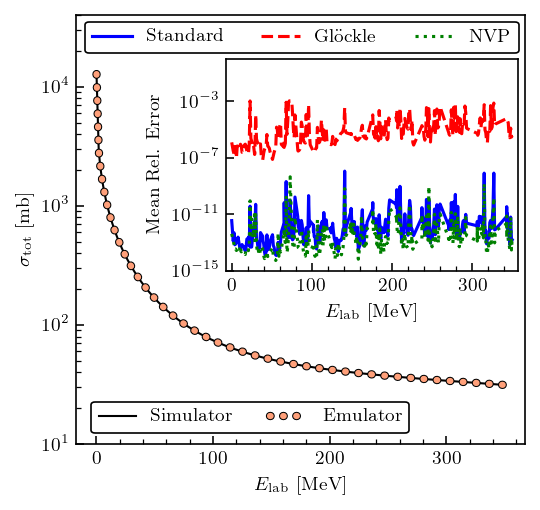

In [62]:
cs_errors = [cs_rel_mean_glockle, cs_rel_mean_std, cs_rel_mean_nvp]
plot_cross_section(E, value, jmax, cs_sim, cs_emu_std, cs_errors)

## Emulate spin observables

In [63]:
spin_obs = EmulateSpinObservables(js, lecs, emulators, solver)

### Spin observables - Simulator

In [64]:
%%time
sp_obs_sim = spin_obs.emulate_spin_obs(compute_obs, true_lecs, 
                                       potentials, nugget, 
                                       glockle=None, emulate=False)

CPU times: user 55.3 s, sys: 2.16 s, total: 57.5 s
Wall time: 7.51 s


### Spin observables - KVP with Std

In [65]:
%%time
sp_obs_emu_std = spin_obs.emulate_spin_obs(compute_obs, true_lecs, 
                                           potentials, nugget, 
                                           glockle=False, emulate=True)

CPU times: user 3.09 s, sys: 60.2 ms, total: 3.15 s
Wall time: 746 ms


In [66]:
dsg_sim = sp_obs_sim['DSG']
D_sim = sp_obs_sim['D']
Ay_sim = sp_obs_sim['PB']
Axx_sim = sp_obs_sim['AXX']
Ayy_sim = sp_obs_sim['AYY']
A_sim = sp_obs_sim['A']

dsg_emu_std = sp_obs_emu_std['DSG']
D_emu_std = sp_obs_emu_std['D']
Ay_emu_std = sp_obs_emu_std['PB']
Axx_emu_std = sp_obs_emu_std['AXX']
Ayy_emu_std = sp_obs_emu_std['AYY']
A_emu_std = sp_obs_emu_std['A']

In [67]:
dsg_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'DSG')[1]
D_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'D')[1]
Ay_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'PB')[1]
Axx_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'AXX')[1]
Ayy_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'AYY')[1]
A_rel_err_std = compute_errors(sp_obs_sim, sp_obs_emu_std, 'A')[1]

### Spin observables - KVP with Glockle

In [68]:
%%time
sp_obs_emu_glockle = spin_obs.emulate_spin_obs(compute_obs, true_lecs, 
                                               potentials, nugget, 
                                               glockle=None, emulate=True)

CPU times: user 3.05 s, sys: 38.3 ms, total: 3.08 s
Wall time: 702 ms


In [69]:
dsg_rel_err_glockle = compute_errors(sp_obs_sim, sp_obs_emu_glockle, 'DSG')[1]
D_rel_err_glockle = compute_errors(sp_obs_sim, sp_obs_emu_glockle, 'D')[1]
Ay_rel_err_glockle = compute_errors(sp_obs_sim, sp_obs_emu_glockle, 'PB')[1]
Ayy_rel_err_glockle = compute_errors(sp_obs_sim, sp_obs_emu_glockle, 'AYY')[1]
A_rel_err_glockle = compute_errors(sp_obs_sim, sp_obs_emu_glockle, 'A')[1]

### Spin observables - NVP

In [70]:
%%time
sp_obs_sim_nvp = nvp_obs.predict(true_lecs_arr, spin_obs=True, full_space=True)

CPU times: user 1min 11s, sys: 3.85 s, total: 1min 14s
Wall time: 10.1 s


In [71]:
%%time
sp_obs_emu_nvp = nvp_obs.predict(true_lecs_arr, spin_obs=True, full_space=False)

CPU times: user 1.81 s, sys: 42.5 ms, total: 1.85 s
Wall time: 414 ms


In [72]:
dsg_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'DSG')[1]
D_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'D')[1]
Ay_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'PB')[1]
Axx_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'AXX')[1]
Ayy_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'AYY')[1]
A_rel_err_nvp = compute_errors(sp_obs_sim_nvp, sp_obs_emu_nvp, 'A')[1]

## Spin observables: predict with sampled parameter sets

In [73]:
spin_obs_sim_sample = np.zeros((num_test), dtype=object)
spin_obs_emu_std_sample = np.zeros((num_test), dtype=object)
spin_obs_emu_glockle_sample = np.zeros((num_test), dtype=object)
spin_obs_sim_nvp_sample = np.zeros((num_test), dtype=object)
spin_obs_emu_nvp_sample = np.zeros((num_test), dtype=object)

### Sampled spin observables - KVP emulator with Std

In [74]:
test_so_emu_std = %timeit -c -o -n 1 -r 1 spin_obs.predict(spin_obs_emu_std_sample, compute_obs, lec_test_all, potentials, nugget, glockle=False, emulate=True)


25min 29s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled spin observables - KVP emulator with Glockle

In [75]:
test_so_emu_glockle = %timeit -c -o -n 1 -r 1 spin_obs.predict(spin_obs_emu_glockle_sample, compute_obs, lec_test_all, potentials, nugget, glockle=True, emulate=True)


25min 34s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled spin observables - Simulator

In [76]:
test_so_sim = %timeit -c -o -n 1 -r 1 spin_obs.predict(spin_obs_sim_sample, compute_obs, lec_test_all, potentials, nugget, glockle=None, emulate=False)


5h 48min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Sampled spin observables - NVP

In [77]:
test_so_emu_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, spin_obs=True, full_space=False, out=spin_obs_emu_nvp_sample)

15min 42s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [78]:
test_so_sim_nvp = %timeit -c -o -n 1 -r 1 nvp_obs.predict(lec_test_all, spin_obs=True, full_space=True, out=spin_obs_sim_nvp_sample)

1h 44min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### Calculate errors

In [79]:
spin_obs_err_std = spin_obs_errors(E, degrees, 
                                   spin_obs_sim_sample, 
                                   spin_obs_emu_std_sample)

dsg_err = spin_obs_err_std[0]
D_err = spin_obs_err_std[1]
Ay_err = spin_obs_err_std[2]
Axx_err = spin_obs_err_std[3]
Ayy_err = spin_obs_err_std[4]
A_err = spin_obs_err_std[5]

dsg_mean_std = np.mean(dsg_err, axis=0)
D_mean_std = np.mean(D_err, axis=0)
Ay_mean_std = np.mean(Ay_err, axis=0)
Axx_mean_std = np.mean(Axx_err, axis=0)
Ayy_mean_std = np.mean(Ayy_err, axis=0)
A_mean_std = np.mean(A_err, axis=0)

dsg_std_angle_avg = np.mean(dsg_mean_std, axis=1)
D_std_angle_avg = np.mean(D_mean_std, axis=1)
Ay_std_angle_avg = np.mean(Ay_mean_std, axis=1)
Axx_std_angle_avg = np.mean(Axx_mean_std, axis=1)
Ayy_std_angle_avg = np.mean(Ayy_mean_std, axis=1)
A_std_angle_avg = np.mean(A_mean_std, axis=1)

In [80]:
spin_obs_err_glockle = spin_obs_errors(E, degrees, 
                                       spin_obs_sim_sample, 
                                       spin_obs_emu_glockle_sample)

dsg_glockle_err = spin_obs_err_glockle[0]
D_glockle_err = spin_obs_err_glockle[1]
Ay_glockle_err = spin_obs_err_glockle[2]
Axx_glockle_err = spin_obs_err_glockle[3]
Ayy_glockle_err = spin_obs_err_glockle[4]
A_glockle_err = spin_obs_err_glockle[5]

dsg_mean_glockle = np.mean(dsg_glockle_err, axis=0)
D_mean_glockle = np.mean(D_glockle_err, axis=0)
Ay_mean_glockle = np.mean(Ay_glockle_err, axis=0)
Axx_mean_glockle = np.mean(Axx_glockle_err, axis=0)
Ayy_mean_glockle = np.mean(Ayy_glockle_err, axis=0)
A_mean_glockle = np.mean(A_glockle_err, axis=0)

dsg_glockle_angle_avg = np.mean(dsg_mean_glockle, axis=1)
D_glockle_angle_avg = np.mean(D_mean_glockle, axis=1)
Ay_glockle_angle_avg = np.mean(Ay_mean_glockle, axis=1)
Axx_glockle_angle_avg = np.mean(Axx_mean_glockle, axis=1)
Ayy_glockle_angle_avg = np.mean(Ayy_mean_glockle, axis=1)
A_glockle_angle_avg = np.mean(A_mean_glockle, axis=1)

In [81]:
spin_obs_err_nvp = spin_obs_errors(E, degrees, 
                                   spin_obs_sim_nvp_sample, 
                                   spin_obs_emu_nvp_sample)

dsg_nvp_err = spin_obs_err_nvp[0]
D_nvp_err = spin_obs_err_nvp[1]
Ay_nvp_err = spin_obs_err_nvp[2]
Axx_nvp_err = spin_obs_err_nvp[3]
Ayy_nvp_err = spin_obs_err_nvp[4]
A_nvp_err = spin_obs_err_nvp[5]

dsg_mean_nvp = np.mean(dsg_nvp_err, axis=0)
D_mean_nvp = np.mean(D_nvp_err, axis=0)
Ay_mean_nvp = np.mean(Ay_nvp_err, axis=0)
Axx_mean_nvp = np.mean(Axx_nvp_err, axis=0)
Ayy_mean_nvp = np.mean(Ayy_nvp_err, axis=0)
A_mean_nvp = np.mean(A_nvp_err, axis=0)

dsg_nvp_angle_avg = np.mean(dsg_mean_nvp, axis=1)
D_nvp_angle_avg = np.mean(D_mean_nvp, axis=1)
Ay_nvp_angle_avg = np.mean(Ay_mean_nvp, axis=1)
Axx_nvp_angle_avg = np.mean(Axx_mean_nvp, axis=1)
Ayy_nvp_angle_avg = np.mean(Ayy_mean_nvp, axis=1)
A_nvp_angle_avg = np.mean(A_mean_nvp, axis=1)

### Sampled spin observables - Timing

In [82]:
test_so_sim.average / test_so_emu_std.average

13.671509276032833

In [83]:
test_so_sim.average / test_so_emu_glockle.average

13.620561938061478

In [84]:
test_so_sim_nvp.average / test_so_emu_nvp.average

6.684359497909882

## Sampled spin observables - Results

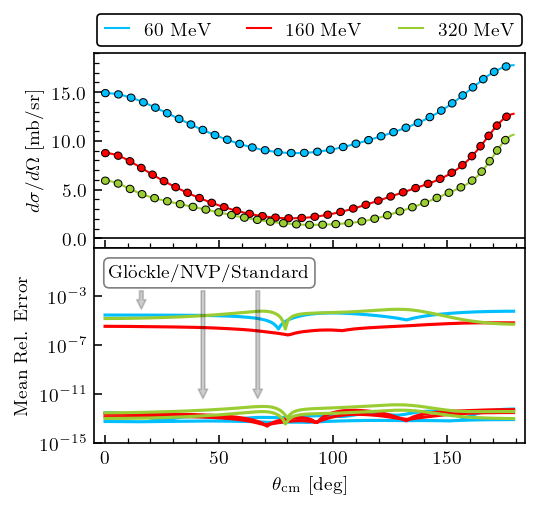

In [85]:
E1 = 60
E2 = 160
E3 = 320

E_arr = [E1, E2, E3]
ylim = [-1, 19]
yarrows = [[4e-5, 6e-3], [2e-12, 6e-3], [2e-12, 6e-3]]
dsg_errors = [dsg_mean_glockle, dsg_mean_std, dsg_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              dsg_sim, dsg_emu_std, dsg_errors, 'dsg')

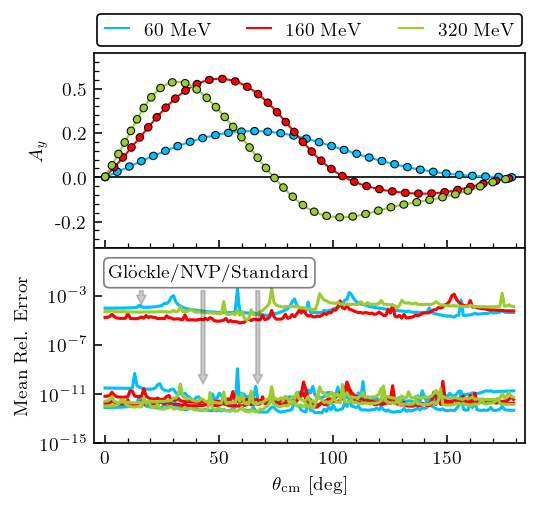

In [86]:
ylim = [-0.4, 0.7]
yarrows = [[9e-5, 6e-3], [3e-11, 6e-3], [3e-11, 6e-3]]
Ay_errors = [Ay_mean_glockle, Ay_mean_std, Ay_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              Ay_sim, Ay_emu_std, Ay_errors, 'Ay')

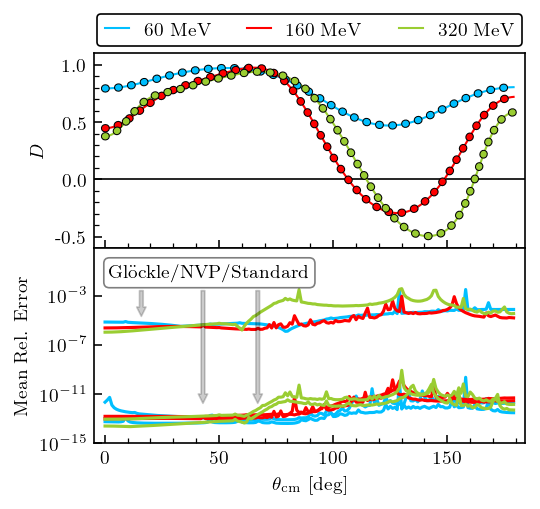

In [87]:
ylim = [-0.6, 1.1]
yarrows = [[1e-5, 6e-3], [8e-13, 6e-3], [8e-13, 6e-3]]
D_errors = [D_mean_glockle, D_mean_std, D_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              D_sim, D_emu_std, D_errors, 'D')

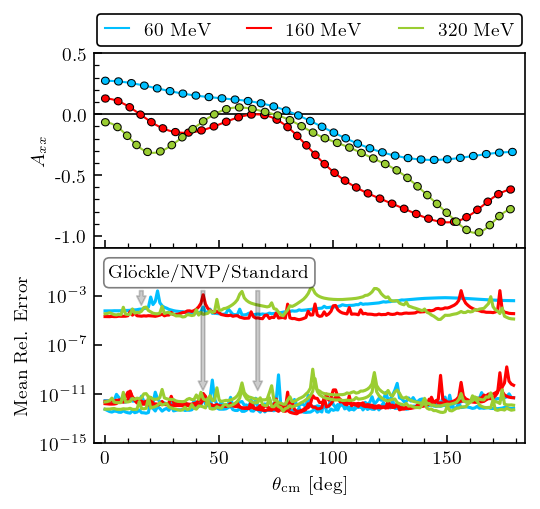

In [88]:
ylim = [-1.1, 0.5]
yarrows = [[8e-5, 6e-3], [9e-12, 6e-3], [9e-12, 6e-3]]
Axx_errors = [Axx_mean_glockle, Axx_mean_std, Axx_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              Axx_sim, Axx_emu_std, Axx_errors, 'Axx')

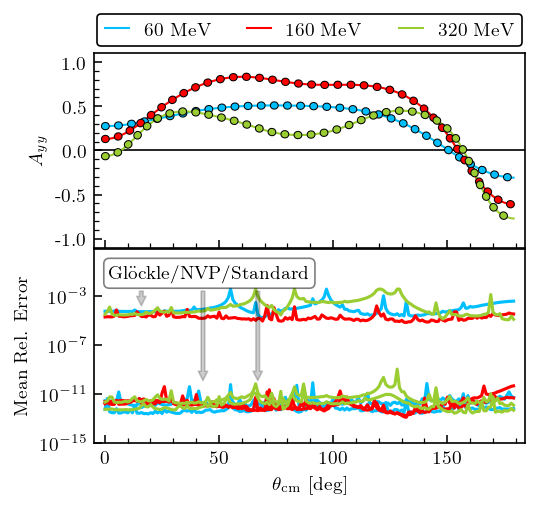

In [89]:
ylim = [-1.1, 1.1]
yarrows = [[8e-5, 6e-3], [6e-11, 6e-3], [6e-11, 6e-3]]
Ayy_errors = [Ayy_mean_glockle, Ayy_mean_std, Ayy_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              Ayy_sim, Ayy_emu_std, Ayy_errors, 'Ayy')

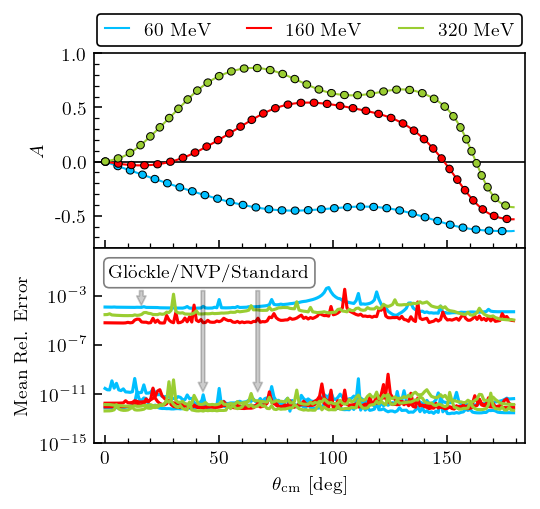

In [90]:
ylim = [-0.8, 1]
yarrows = [[8e-5, 6e-3], [7e-12, 6e-3], [7e-12, 6e-3]]
A_errors = [A_mean_glockle, A_mean_std, A_mean_nvp]
plot_spin_obs(degrees, E_arr, value, jmax, ylim, yarrows,
              A_sim, A_emu_std, A_errors, 'A')

### Sampled spin observables - Analytics

In [91]:
E1 = 5
E2 = 100
E3 = 200
E4 = 300
E_table = [E1, E2, E3, E4]

print('Avg. Rel. error: angle averaged')
print('--------------------------------------')

for E_i in E_table:
    print('Energy:', E_i)
    print('Obs. ', '  Std. ', ' Glockle ', ' NVP ')
    print(f'DSG: ' f'{dsg_std_angle_avg[E_i]:.2e} '
                   f'{dsg_glockle_angle_avg[E_i]:.2e} '
                   f'{dsg_nvp_angle_avg[E_i]:.2e}')
    print(f'D  : ' f'{D_std_angle_avg[E_i]:.2e} '
                   f'{D_glockle_angle_avg[E_i]:.2e} '
                   f'{D_nvp_angle_avg[E_i]:.2e}')
    print(f'Ay : ' f'{Ay_std_angle_avg[E_i]:.2e} '
                   f'{Ay_glockle_angle_avg[E_i]:.2e} '
                   f'{Ay_nvp_angle_avg[E_i]:.2e}')
    print(f'Axx: ' f'{Axx_std_angle_avg[E_i]:.2e} '
                   f'{Axx_glockle_angle_avg[E_i]:.2e} '
                   f'{Axx_nvp_angle_avg[E_i]:.2e}')
    print(f'Ayy: ' f'{Ayy_std_angle_avg[E_i]:.2e} '
                   f'{Ayy_glockle_angle_avg[E_i]:.2e} '
                   f'{Ayy_nvp_angle_avg[E_i]:.2e}')
    print(f'A  : ' f'{A_std_angle_avg[E_i]:.2e} '
                   f'{A_glockle_angle_avg[E_i]:.2e} '
                   f'{A_nvp_angle_avg[E_i]:.2e}')
    print('\n')

Avg. Rel. error: angle averaged
--------------------------------------
Energy: 5
Obs.    Std.   Glockle   NVP 
DSG: 8.81e-11 1.08e-07 9.13e-12
D  : 1.45e-09 7.31e-07 1.41e-10
Ay : 1.57e-09 2.20e-06 2.62e-10
Axx: 2.64e-09 7.94e-07 2.32e-10
Ayy: 3.00e-09 1.59e-06 2.35e-10
A  : 5.44e-09 1.15e-06 2.60e-10


Energy: 100
Obs.    Std.   Glockle   NVP 
DSG: 1.14e-12 4.57e-07 1.38e-13
D  : 1.08e-11 7.13e-06 1.02e-12
Ay : 3.01e-11 1.27e-05 7.43e-12
Axx: 2.43e-11 1.84e-05 5.81e-12
Ayy: 4.72e-11 1.23e-05 1.20e-11
A  : 1.46e-11 5.22e-06 4.28e-12


Energy: 200
Obs.    Std.   Glockle   NVP 
DSG: 2.18e-10 1.01e-04 6.30e-12
D  : 1.49e-09 6.02e-04 5.27e-11
Ay : 1.48e-08 2.12e-03 2.47e-10
Axx: 1.89e-09 8.59e-04 8.09e-11
Ayy: 4.35e-09 1.20e-03 1.41e-10
A  : 9.62e-09 1.07e-03 4.63e-10


Energy: 300
Obs.    Std.   Glockle   NVP 
DSG: 2.32e-12 1.36e-05 2.83e-12
D  : 3.00e-11 1.10e-04 1.79e-11
Ay : 2.63e-11 1.38e-04 5.88e-11
Axx: 3.39e-11 1.43e-04 3.65e-11
Ayy: 1.35e-10 1.76e-04 3.84e-11
A  : 2.99e-11 1.19e-0

In [92]:
E1 = 5
E2 = 100
E3 = 200
E4 = 300
E_table = [E1, E2, E3, E4]

print('Log of Avg. Rel. error: angle averaged')
print('--------------------------------------')

for E_i in E_table:
    print('Energy:', E_i)
    print('Obs. ', '  Std. ', ' Glockle ', ' NVP ')
    print(f'DSG: ' f'{np.log10(dsg_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(dsg_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(dsg_nvp_angle_avg[E_i]):.2e}')
    print(f'D  : ' f'{np.log10(D_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(D_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(D_nvp_angle_avg[E_i]):.2e}')
    print(f'Ay : ' f'{np.log10(Ay_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(Ay_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(Ay_nvp_angle_avg[E_i]):.2e}')
    print(f'Axx: ' f'{np.log10(Axx_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(Axx_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(Axx_nvp_angle_avg[E_i]):.2e}')
    print(f'Ayy: ' f'{np.log10(Ayy_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(Ayy_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(Ayy_nvp_angle_avg[E_i]):.2e}')
    print(f'A  : ' f'{np.log10(A_std_angle_avg[E_i]):.2e} '
                   f'{np.log10(A_glockle_angle_avg[E_i]):.2e} '
                   f'{np.log10(A_nvp_angle_avg[E_i]):.2e}')
    print('\n')

Log of Avg. Rel. error: angle averaged
--------------------------------------
Energy: 5
Obs.    Std.   Glockle   NVP 
DSG: -1.01e+01 -6.97e+00 -1.10e+01
D  : -8.84e+00 -6.14e+00 -9.85e+00
Ay : -8.80e+00 -5.66e+00 -9.58e+00
Axx: -8.58e+00 -6.10e+00 -9.63e+00
Ayy: -8.52e+00 -5.80e+00 -9.63e+00
A  : -8.26e+00 -5.94e+00 -9.59e+00


Energy: 100
Obs.    Std.   Glockle   NVP 
DSG: -1.19e+01 -6.34e+00 -1.29e+01
D  : -1.10e+01 -5.15e+00 -1.20e+01
Ay : -1.05e+01 -4.90e+00 -1.11e+01
Axx: -1.06e+01 -4.73e+00 -1.12e+01
Ayy: -1.03e+01 -4.91e+00 -1.09e+01
A  : -1.08e+01 -5.28e+00 -1.14e+01


Energy: 200
Obs.    Std.   Glockle   NVP 
DSG: -9.66e+00 -4.00e+00 -1.12e+01
D  : -8.83e+00 -3.22e+00 -1.03e+01
Ay : -7.83e+00 -2.67e+00 -9.61e+00
Axx: -8.72e+00 -3.07e+00 -1.01e+01
Ayy: -8.36e+00 -2.92e+00 -9.85e+00
A  : -8.02e+00 -2.97e+00 -9.33e+00


Energy: 300
Obs.    Std.   Glockle   NVP 
DSG: -1.16e+01 -4.87e+00 -1.15e+01
D  : -1.05e+01 -3.96e+00 -1.07e+01
Ay : -1.06e+01 -3.86e+00 -1.02e+01
Axx: -1.05e+01 